# Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import json
import os

## VQADataset

In [32]:
import json
import os
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer
from PIL import Image

class VQADataset(Dataset):
    def __init__(self, json_file, image_folder, transform=None):
        with open(json_file, 'r') as f:
            self.data = json.load(f)

        self.image_folder = image_folder
        self.transform = transform

        # Initialize BERT tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.samples = []  # Danh sách lưu trữ dữ liệu đã xử lý

        for img_name, qa in self.data.items():
            img_path = os.path.join(self.image_folder, img_name)

            for q, a in zip(qa['questions'], qa['answers']):
                # Tokenize câu hỏi
                encoded_question = self.tokenizer(
                    q, 
                    truncation=True, 
                    return_tensors='pt'
                )

                # Tokenize câu trả lời
                encoded_answer = self.tokenizer(
                    a, 
                    truncation=True, 
                    return_tensors='pt'
                )

                self.samples.append({
                    "image_path": img_path,
                    "input_ids": encoded_question["input_ids"].squeeze(0),
                    "attention_mask": encoded_question["attention_mask"].squeeze(0),
                    "answer": encoded_answer["input_ids"].squeeze(0),
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample["image_path"]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return {
            "image": image,
            "input_ids": sample["input_ids"],
            "attention_mask": sample["attention_mask"],
            "answer": sample["answer"],
        }


In [33]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    images = torch.stack([item["image"] for item in batch])  # Batch images

    input_ids = [item["input_ids"] for item in batch]
    attention_masks = [item["attention_mask"] for item in batch]
    answers = [item["answer"] for item in batch]

    # Apply padding only at batch time
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    answers_padded = pad_sequence(answers, batch_first=True, padding_value=0)

    return {
        "images": images,
        "input_ids": input_ids_padded,
        "attention_masks": attention_masks_padded,
        "answers": answers_padded,
    }


## Data preprocessing

In [34]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = VQADataset(json_file='data/vqadata_sample.json', image_folder='data/Vehicles', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Define train-test split
train_ratio = 0.8
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Split dataset into train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Building Seq2Seq VQA Model 

## VQA Encoder Layer

In [55]:
# Encoder: Feature Extraction for Image + LSTM for Question Encoding
class VQAEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pretrained=True,use_attention=True):
        super(VQAEncoder, self).__init__()
        self.use_attention = use_attention
        
        # CNN Feature Extractor (Pretrained ResNet18)
        self.cnn = models.resnet18(pretrained=pretrained)
        self.cnn.fc = nn.Identity()  # Output shape: (batch, 512)
        
        # Question Embedding + LSTM
        self.embedding = nn.Embedding(vocab_size, embed_dim,padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        
        # Attention Layer (optional)
        if self.use_attention:
            self.attention = nn.Linear(hidden_dim + 512, hidden_dim)  # Simple attention layer
        
    def forward(self, image, question):
        img_features = self.cnn(image)  # Shape: (batch, 512)
        
        ques_embedded = self.embedding(question)  # Shape: (batch, seq_len, embed_dim)
        _, (ques_features, _) = self.lstm(ques_embedded)  # (1, batch, hidden_dim)
        ques_features = ques_features.squeeze(0) # Extract last hidden state: (batch, hidden_dim)
        
        if self.use_attention:
            combined_features = torch.cat((img_features, ques_features), dim=1)  # (batch, 512 + hidden_dim)
            encoded = torch.tanh(self.attention(combined_features))  # (batch, hidden_dim)
        else:
            encoded = ques_features  + img_features # (batch, hidden_dim)
        
        return encoded  # Final representation for Decoder

## VQA Decoder Layer

In [56]:
# Decoder: LSTM to Generate Answer Sequence
class VQADecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(VQADecoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim + hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)  # Predict next word
        
    def forward(self, encoder_output, answer_input):
        answer_embedded = self.embedding(answer_input)  # (batch, ans_seq_len, embed_dim)
        
        # Repeat encoder output across sequence length
        expanded_encoder_output = encoder_output.unsqueeze(1).expand(-1, answer_embedded.shape[1], -1)  
        
        lstm_input = torch.cat((answer_embedded, expanded_encoder_output), dim=2)  # (batch, seq_len, embed_dim + hidden_dim)
        
        lstm_out, _ = self.lstm(lstm_input)
        output = self.fc(lstm_out)  # Predict each word in sequence
        
        return output  # (batch, seq_len, vocab_size)

## Full VQA Seq2Seq Model 

In [57]:
# Full VQA Seq2Seq Model
class Seq2SeqVQA(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pretrained=True, use_attention=True):
        super(Seq2SeqVQA, self).__init__()
        self.encoder = VQAEncoder(vocab_size, embed_dim, hidden_dim, pretrained, use_attention)
        self.decoder = VQADecoder(vocab_size, embed_dim, hidden_dim)
    
    def forward(self, image, question, answer_input):
        encoded_features = self.encoder(image, question)
        output = self.decoder(encoded_features, answer_input)
        return output


## Training Function

In [38]:
import torch.optim as optim
last_lost = 0.0
def train_seq2seq_vqa(model, train_loader, criterion, optimizer, device, epochs=5):
    loss_history = [] 
    
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0.0

        for batch in train_loader:
            images = batch["images"].to(device)
            input_ids = batch["input_ids"].to(device)
            answers = batch["answers"].to(device)

            optimizer.zero_grad()

            # Forward pass
            output = model(images, input_ids, answers[:, :-1])  # Shift right for teacher forcing

            # Compute loss
            loss = criterion(output.reshape(-1, output.shape[-1]), answers[:, 1:].reshape(-1))  # Shift right target

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)  # Compute average loss
        loss_history.append(avg_loss)  # Store loss for this epoch

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")
        last_lost = total_loss / len(train_loader)
        
    print("Training Complete!")
    
    return loss_history


## Train the model

In [86]:
# Model parameters
vocab_size = 30522  # Assume vocabulary size
embed_dim = 300
hidden_dim = 512
pretrained = True  # Use pretrained CNN
attention = False # Use attention mechanism

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using: ",device)
# Initialize model
model = Seq2SeqVQA(vocab_size, embed_dim, hidden_dim, pretrained, attention).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding token
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
loss_history = train_seq2seq_vqa(model, train_loader, criterion, optimizer, device, epochs=50)


using:  cuda
Epoch [1/50], Loss: 3.3940
Epoch [2/50], Loss: 2.0442
Epoch [3/50], Loss: 1.6162
Epoch [4/50], Loss: 1.3446
Epoch [5/50], Loss: 1.1426
Epoch [6/50], Loss: 0.9755
Epoch [7/50], Loss: 0.8394
Epoch [8/50], Loss: 0.7252
Epoch [9/50], Loss: 0.6269
Epoch [10/50], Loss: 0.5499
Epoch [11/50], Loss: 0.4830
Epoch [12/50], Loss: 0.4213
Epoch [13/50], Loss: 0.3719
Epoch [14/50], Loss: 0.3281
Epoch [15/50], Loss: 0.2893
Epoch [16/50], Loss: 0.2577
Epoch [17/50], Loss: 0.2300
Epoch [18/50], Loss: 0.2015
Epoch [19/50], Loss: 0.1847
Epoch [20/50], Loss: 0.1678
Epoch [21/50], Loss: 0.1505
Epoch [22/50], Loss: 0.1340
Epoch [23/50], Loss: 0.1210
Epoch [24/50], Loss: 0.1102
Epoch [25/50], Loss: 0.1033
Epoch [26/50], Loss: 0.0923
Epoch [27/50], Loss: 0.0861
Epoch [28/50], Loss: 0.0766
Epoch [29/50], Loss: 0.0647
Epoch [30/50], Loss: 0.0555
Epoch [31/50], Loss: 0.0508
Epoch [32/50], Loss: 0.0502
Epoch [33/50], Loss: 0.0526
Epoch [34/50], Loss: 0.0526
Epoch [35/50], Loss: 0.0513
Epoch [36/50], L

## Predict answer Function

In [40]:
import torch
import torchvision.transforms as transforms
from PIL import Image

def predict_answer(model, image_path, question_text, tokenizer, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  

    question_tokens = tokenizer(
        question_text,
        truncation=True,
        return_tensors="pt")
    question_tensor = question_tokens["input_ids"].to(device)  

    model.eval()
    with torch.no_grad():
        encoded_features = model.encoder(image_tensor, question_tensor)

        answer_input = torch.tensor([[tokenizer.cls_token_id]], dtype=torch.long).to(device)  
        generated_answer = []

        while True:  # Infinite loop until SEP token is found
            # Decode step-by-step
            output = model.decoder(encoded_features, answer_input)  # Shape: (1, seq_len, vocab_size)
            next_token_logits = output[:, -1, :]  # Get last predicted word
            predicted_id = torch.argmax(next_token_logits, dim=-1).item()  # Get token ID
            
            # Stop if <SEP> token is generated
            if predicted_id == tokenizer.sep_token_id:
                break  
            
            # Store the generated token
            generated_answer.append(predicted_id)
            
            # Append predicted token to the answer input sequence
            answer_input = torch.cat([answer_input, torch.tensor([[predicted_id]], dtype=torch.long).to(device)], dim=1)

    # Convert generated token IDs to text
    answer_text = tokenizer.decode(generated_answer, skip_special_tokens=True)

    return answer_text


## Test

In [87]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Đường dẫn đến ảnh test
image_path = 'test_bike1.jpg'

# Câu hỏi
question_list = ["What type of vehicle is shown in the image?"]

# Dự đoán câu trả lời
for question in question_list:
    predicted_answer = predict_answer(model, image_path, question, tokenizer, device)
    print(f"Predicted Answer: {predicted_answer}")

Predicted Answer: the vehicle is a bicycle.


## Save the current model

In [88]:
checkpoint_path = "model/vqa_model_no_att_and_pre_v3.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 50,
    'loss': last_lost
}, checkpoint_path)

print(f"Checkpoint saved to {checkpoint_path}")


Checkpoint saved to model/vqa_model_no_att_and_pre_v3.pth


## Model Full Architecture

In [83]:
print(model)

Seq2SeqVQA(
  (encoder): VQAEncoder(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo

## Plot the Loss History

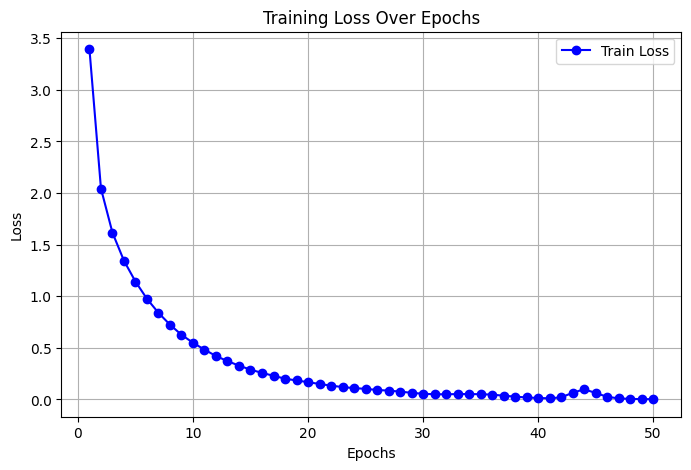

In [89]:
import matplotlib.pyplot as plt
# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-', color='b', label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()


## Test and compare all the model

In [84]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from transformers import BertTokenizer

def test_model(model):
    # Load BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # List of test images
    image_list = ['test_bike1.jpg', 
                  'test_car1.jpg', 
                  'test_plane1.jpg',
                  'test_train1.jpg']
    
    # List of test questions
    question_list = ["What type of vehicle is shown in the image?",
                     "What is the dominant color of the vehicle?",
                     "What is the probable use of this vehicle?",]
    
    # Predict answers for each image-question pair
    for image_path in image_list:
        # Load and display the image
        image = Image.open(image_path).convert("RGB")  # Ensure RGB format
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Image: {image_path}")
        plt.show()

        # Predict answers for each question
        for question in question_list:
            predicted_answer = predict_answer(model, image_path, question, tokenizer, device)
            print(f"Question: {question}")
            print(f"Predicted Answer: {predicted_answer}\n")


## Result 

C:\Users\Huu Khanh - Computer\AppData\Local\Temp\ipykernel_17036\2618452651.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path1, map_loc

------The predict answers of Model using Attention and Pretrained Model------


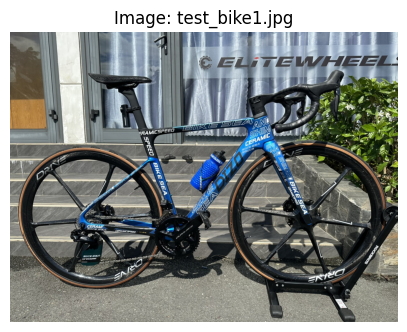

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle is a bicycle.

Question: What is the dominant color of the vehicle?
Predicted Answer: the dominant color is white.

Question: What is the probable use of this vehicle?
Predicted Answer: transportation and / or commuting.



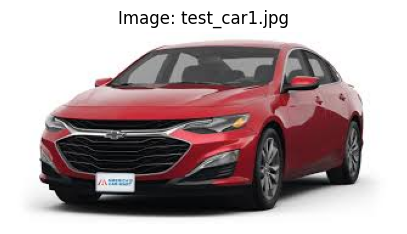

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle is a car.

Question: What is the dominant color of the vehicle?
Predicted Answer: the car is predominantly white.

Question: What is the probable use of this vehicle?
Predicted Answer: personal transportation and commuting.



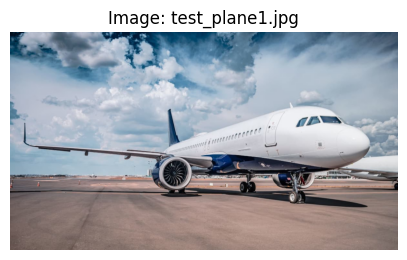

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle is an airplane.

Question: What is the dominant color of the vehicle?
Predicted Answer: the aircraft is predominantly black.

Question: What is the probable use of this vehicle?
Predicted Answer: personal transport or small cargo transport.



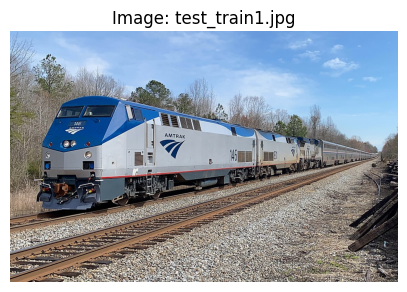

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle is a train.

Question: What is the dominant color of the vehicle?
Predicted Answer: the dominant color is black.

Question: What is the probable use of this vehicle?
Predicted Answer: likely for personal transportation.

--------------------------------------------------------------------

------The predict answers of Model using Attention and NO Pretrained Model------


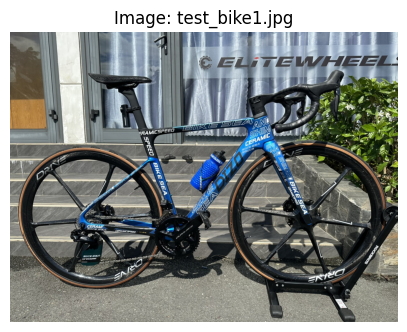

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle is a bicycle.

Question: What is the dominant color of the vehicle?
Predicted Answer: the vehicle is a bicycle.

Question: What is the probable use of this vehicle?
Predicted Answer: transportation or recreation.



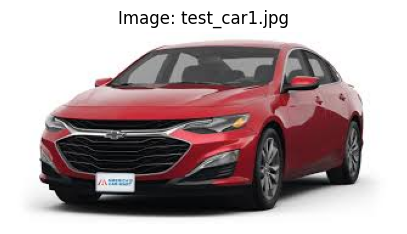

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle shown is a car.

Question: What is the dominant color of the vehicle?
Predicted Answer: the train is primarily white.

Question: What is the probable use of this vehicle?
Predicted Answer: personal transportation is the probable use.



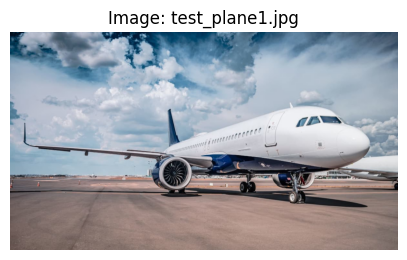

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle is an airplane.

Question: What is the dominant color of the vehicle?
Predicted Answer: the train is primarily white.

Question: What is the probable use of this vehicle?
Predicted Answer: personal transportation or recreational use.



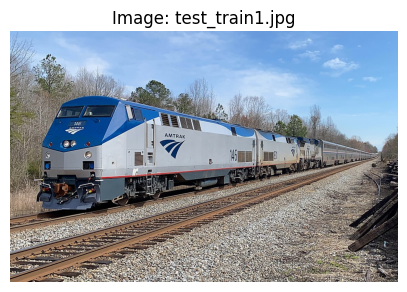

Question: What type of vehicle is shown in the image?
Predicted Answer: the image shows a train.

Question: What is the dominant color of the vehicle?
Predicted Answer: the train is primarily white.

Question: What is the probable use of this vehicle?
Predicted Answer: personal transportation is probable use.

--------------------------------------------------------------------

------The predict answers of Model using NO Attention and Pretrained Model------


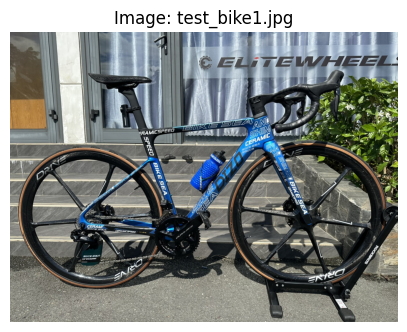

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle is a bicycle.

Question: What is the dominant color of the vehicle?
Predicted Answer: the bicycle frame is black.

Question: What is the probable use of this vehicle?
Predicted Answer: likely for commuting or recreational riding.



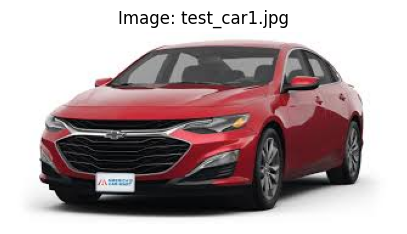

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle is a car.

Question: What is the dominant color of the vehicle?
Predicted Answer: the weather is good visibility.

Question: What is the probable use of this vehicle?
Predicted Answer: likely for personal transportation.



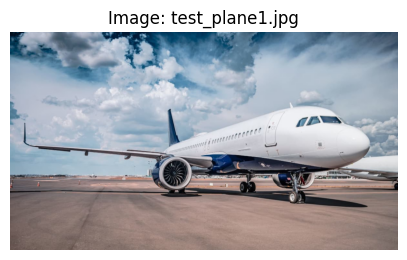

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle is identified as a train.

Question: What is the dominant color of the vehicle?
Predicted Answer: the weather is predominantly white.

Question: What is the probable use of this vehicle?
Predicted Answer: likely for personal transportation or commuting.



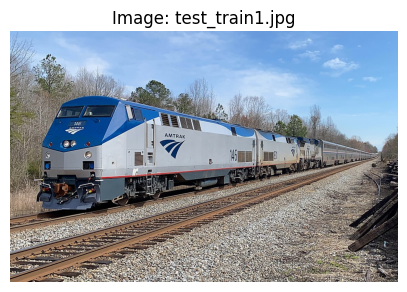

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle is a car.

Question: What is the dominant color of the vehicle?
Predicted Answer: the weather is good visibility.

Question: What is the probable use of this vehicle?
Predicted Answer: likely for personal transportation or commuting.

--------------------------------------------------------------------

------The predict answers of Model using NO Attention and NO Pretrained Model------


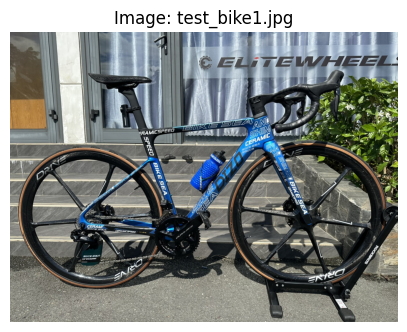

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle is a bicycle.

Question: What is the dominant color of the vehicle?
Predicted Answer: the vehicle is a helmet.

Question: What is the probable use of this vehicle?
Predicted Answer: personal transportation or commuting.



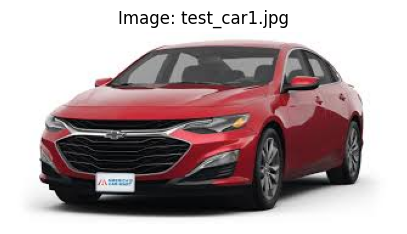

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle shown is a car.

Question: What is the dominant color of the vehicle?
Predicted Answer: the vehicle is a car.

Question: What is the probable use of this vehicle?
Predicted Answer: personal transportation is the probable use.



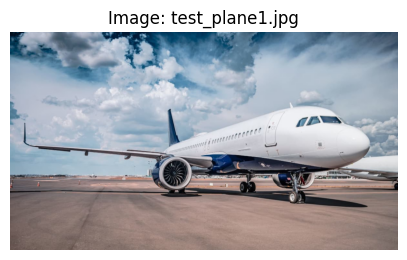

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle is an airplane.

Question: What is the dominant color of the vehicle?
Predicted Answer: the vehicle is identified as a black.

Question: What is the probable use of this vehicle?
Predicted Answer: personal transportation or commuting.



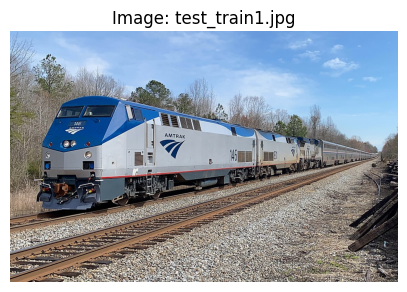

Question: What type of vehicle is shown in the image?
Predicted Answer: the vehicle is an airplane.

Question: What is the dominant color of the vehicle?
Predicted Answer: the dominant color is black.

Question: What is the probable use of this vehicle?
Predicted Answer: personal transportation or commuting.

--------------------------------------------------------------------



In [91]:
# Load the saved model
vocab_size = 30522
embed_dim = 300
hidden_dim = 512
pretrained = True
use_attention = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model with Attention and Pretrained Model
model_path1 = "model/vqa_model_att_and_pre.pth"
mode_using_attention_and_pretrained = Seq2SeqVQA(vocab_size, embed_dim, hidden_dim, pretrained=True, use_attention=True).to(device)

checkpoint = torch.load(model_path1, map_location=device)
# Extract only the model's state_dict
mode_using_attention_and_pretrained.load_state_dict(checkpoint["model_state_dict"])  

# Model with Attention and NO Pretrained Model
model_path2 = "model/vqa_model_att_and_no_pre.pth"
mode_using_attention_and_no_pretrained = Seq2SeqVQA(vocab_size, embed_dim, hidden_dim, pretrained=False, use_attention=True).to(device)
checkpoint = torch.load(model_path2, map_location=device)
# Extract only the model's state_dict
mode_using_attention_and_no_pretrained.load_state_dict(checkpoint["model_state_dict"])  

# Model without Attention and Using Pretrained Model
model_path3 = "model/vqa_model_no_att_and_pre.pth"
mode_using_no_attention_and_pretrained = Seq2SeqVQA(vocab_size, embed_dim, hidden_dim, pretrained=True, use_attention=False).to(device)
checkpoint = torch.load(model_path3, map_location=device)
# Extract only the model's state_dict
mode_using_no_attention_and_pretrained.load_state_dict(checkpoint["model_state_dict"])  

# Model without Attention and Pretrained Model
model_path4 = "model/vqa_model_no_att_and_no_pre.pth"
mode_using_no_attention_and_no_pretrained = Seq2SeqVQA(vocab_size, embed_dim, hidden_dim, pretrained=False, use_attention=False).to(device)
checkpoint = torch.load(model_path4, map_location=device)
# Extract only the model's state_dict
mode_using_no_attention_and_no_pretrained.load_state_dict(checkpoint["model_state_dict"])  

# Testing the model
print("------The predict answers of Model using Attention and Pretrained Model------")
test_model(mode_using_attention_and_pretrained)
print(f"--------------------------------------------------------------------\n")

print("------The predict answers of Model using Attention and NO Pretrained Model------")
test_model(mode_using_attention_and_no_pretrained)
print(f"--------------------------------------------------------------------\n")

print("------The predict answers of Model using NO Attention and Pretrained Model------")
test_model(mode_using_no_attention_and_pretrained)
print(f"--------------------------------------------------------------------\n")

print("------The predict answers of Model using NO Attention and NO Pretrained Model------")
test_model(mode_using_no_attention_and_no_pretrained)
print(f"--------------------------------------------------------------------\n")